## Surface Determination Workflow  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import sys
from tomo_encoders import Patches, DataFile
import tensorflow as tf
import time, glob
import open3d as o3d
import cupy as cp

sys.path.append('/data02/MyArchive/aisteer_3Dencoders/TomoEncoders/scratchpad/surface_determination/trainer')
from tomo_encoders.neural_nets.surface_segmenter import SurfaceSegmenter
from tomo_encoders.misc.feature_maps_vis import view_midplanes
from tomo_encoders.misc.voxel_processing import normalize_volume_gpu
from tomo_encoders.misc.viewer import view_midplanes
from tqdm import tqdm

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
gt_path = '/data02/MyArchive/tomo_datasets/ZEISS_try2/GT_VOLS/Sample2'
psize = (16,16,16)
size_lab = '16x16'

In [3]:
ds_gt = DataFile(gt_path, tiff = True, VERBOSITY = 0)
vol_gt = ds_gt.read_full()

In [4]:
p = Patches(None, initialize_by = 'file', fpath = f'/data02/MyArchive/tomo_datasets/ZEISS_try2/sample2_edge_patches_{size_lab}.hdf5')
y_true = p.extract(vol_gt, psize)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

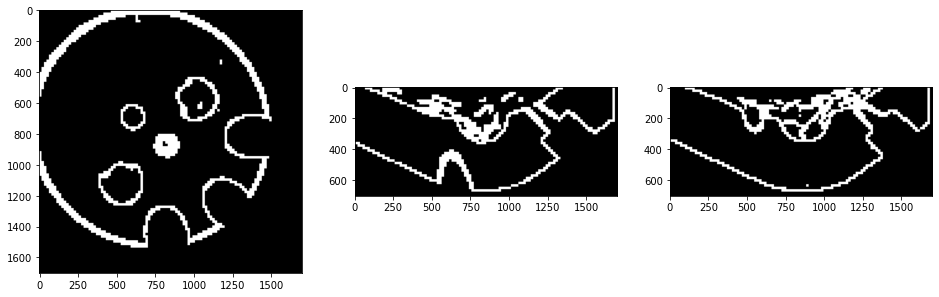

In [5]:
vol_out = np.zeros(p.vol_shape)
vols = np.ones((len(p),) + psize)
p.fill_patches_in_volume(vols, vol_out)
fig, ax = plt.subplots(1,3, figsize = (16,8))
view_midplanes(vol_out, ax = ax)

## Measure IoU in datasets

In [6]:
from tomo_encoders.misc.img_stats import calc_SNR, calc_jac_acc, calc_dice_coeff
from tomo_encoders import DataFile
import pandas as pd

In [7]:
def make_binary_structure(radius, ndim = 3):
    struct_size = 2*radius + 1
    struct = np.ones(tuple([struct_size]*ndim))

    r = np.arange(-radius, radius + 1)

    yy, xx = np.meshgrid(r, r, indexing = 'ij')
    dist = np.sqrt(yy**2 + xx**2)
    struct[dist > radius] = 0
    return struct

In [8]:
from cupyx.scipy.ndimage import binary_erosion, binary_dilation

In [9]:
cols = ["radius", "iou", "dice"]
df = pd.DataFrame(columns = cols)

In [10]:
radii = np.arange(-3,4)
iou = []
for ii, radius in enumerate(radii):
    
    
    if radius < 0:
        struct = make_binary_structure(-radius, ndim = 3)
        vol_seg = binary_erosion(cp.array(vol_gt), structure = cp.array(struct)).get().astype(np.uint8)
    elif radius > 0:
        struct = make_binary_structure(radius, ndim = 3)
        vol_seg = binary_dilation(cp.array(vol_gt), structure = cp.array(struct)).get().astype(np.uint8)
    else:
        vol_seg = vol_gt.copy()
    
    
    y_seg = p.extract(vol_seg, psize)
    iou = calc_jac_acc(y_true, y_seg)
    dice = calc_dice_coeff(y_true, y_seg)
    
    new_item = dict(zip(cols, [radius, iou, dice]))
    
    print(f'{new_item}')
    df = df.append(new_item,ignore_index = True)
    df.to_csv('/home/atekawade/Dropbox/Arg/transfers/ZEISS_v2/morpho_resolution.csv', index = False)

{'radius': -3, 'iou': 0.6302247950716771, 'dice': 0.7731753260864159}
{'radius': -2, 'iou': 0.746748973539382, 'dice': 0.8550157853409703}
{'radius': -1, 'iou': 0.8688904995183742, 'dice': 0.9298463439534664}
{'radius': 0, 'iou': 1.0, 'dice': 1.0}
{'radius': 1, 'iou': 0.884824604128956, 'dice': 0.9388933080334431}
{'radius': 2, 'iou': 0.7957743558599312, 'dice': 0.8862743281087354}
{'radius': 3, 'iou': 0.7201916041945541, 'dice': 0.837338819422142}


In [11]:
diff = vol_gt != vol_seg

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

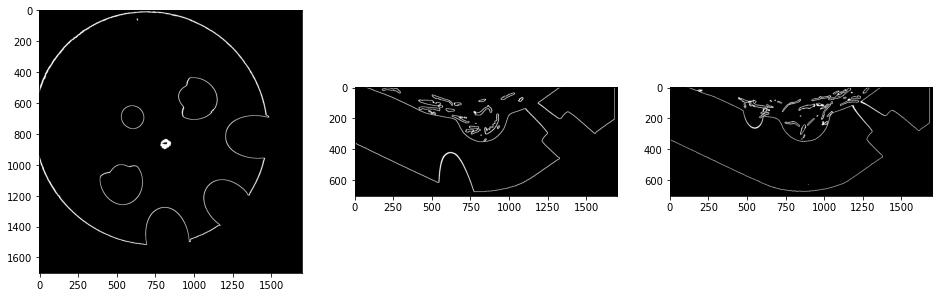

In [12]:
fig, ax = plt.subplots(1,3, figsize = (16,8))
view_midplanes(diff, ax = ax)

In [13]:
diff.shape

(700, 1700, 1700)

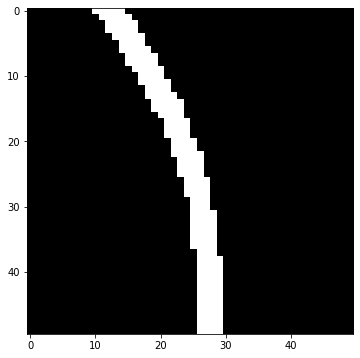

In [14]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
ax.imshow(diff[350,650:700,650:700], cmap = 'gray')

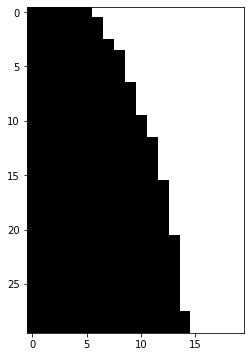

In [15]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
ax.imshow(vol_gt[350,660:690,665:685], cmap = 'gray')

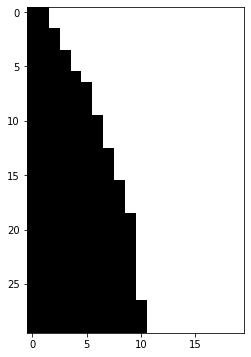

In [16]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
ax.imshow(vol_seg[350,660:690,665:685], cmap = 'gray')

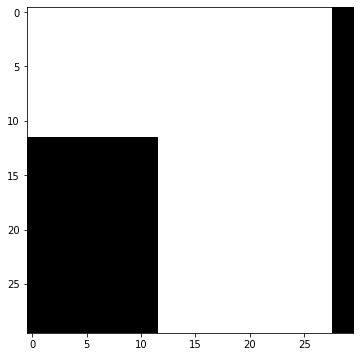

In [17]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
ax.imshow(vol_out[350,660:690,660:690], cmap = 'gray')

In [18]:
df.to_csv('/home/atekawade/Dropbox/Arg/transfers/ZEISS_v2/morpho_resolution.csv', index = False)

In [19]:
df

,radius,iou,dice
0,-3.0,0.630225,0.773175
1,-2.0,0.746749,0.855016
2,-1.0,0.868890,0.929846
3,0.0,1.000000,1.000000
4,1.0,0.884825,0.938893
5,2.0,0.795774,0.886274
6,3.0,0.720192,0.837339
